<h2>This notebook tackles pneumonia classification using CNN (Convolutional Neural Network). In addition, this will also experiment with threshold values.

<br><br>Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli. Typically, symptoms include some combination of productive or dry cough, chest pain, fever and difficulty breathing. </h2>

<h3> Learn more from: <a href='https://www.who.int/news-room/fact-sheets/detail/pneumonia'>World Health Organization</a> </h3>
<h3>Accuracy on testing set: 0.9598976109215017
<br>Precision on testing set: 0.9118541033434651
<br>Recall on testing set: 0.9433962264150944</h3>
<h3>Feel free to leave a comment</h3>
<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Chest_X-ray_in_influenza_and_Haemophilus_influenzae_-_annotated.jpg/1200px-Chest_X-ray_in_influenza_and_Haemophilus_influenzae_-_annotated.jpg' alt='Pneumonia' height='800' width='300'> </center>
<p>Source: Wikipedia</p>

In [64]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pickle
import os
import numpy as np
import cv2
%matplotlib inline

<h2>Process the images and resize them to the preferred size </h2>

In [65]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object) # Set the dtype to object to handle inconsistent shapes

<h2>Preparing the training and testing data</h2>

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

In [67]:
train = get_training_data('/content/dataset/chest_xray/train')
test = get_training_data('/content/dataset/chest_xray/test')
val = get_training_data('/content/dataset/chest_xray/val')

In [68]:
pnenumonia = 0
normal = 0

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1

print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


<h2>Visualize training images</h2>

PNEUMONIA


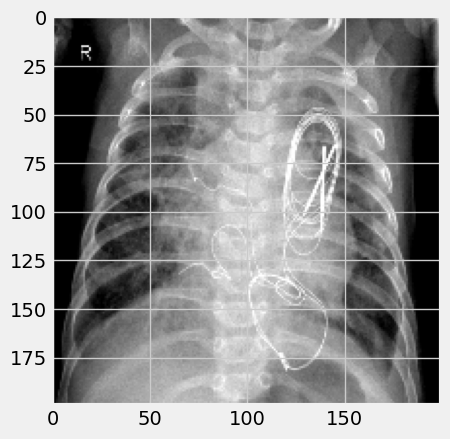

In [69]:
plt.imshow(train[1][0], cmap='gray')
print(labels[train[1][1]])

<h2 >We are incoprating the validation data into the training data because it does not contain enough examples. </h2>

In [70]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)

for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [71]:
X_train = X_train / 255
X_test = X_test / 255

<h2 >CNN (Convolutional Neural Network) </h2>
Image source: https://www.researchgate.net/publication/321286547/figure/download/fig6/AS:564402564472832@1511575465150/A-convolutional-neural-networks-CNN.png

![](https://www.researchgate.net/publication/321286547/figure/download/fig6/AS:564402564472832@1511575465150/A-convolutional-neural-networks-CNN.png)

In [72]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss')
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [73]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 200, 200, 256)       │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 200, 200, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 100, 100, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100, 100, 256)       │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 100, 100, 64)        │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 50, 50, 64)          │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 16)          │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 50, 50, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25, 25, 16)          │             100 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 800,141 (3.05 MB)

 Trainable params: 799,791 (3.05 MB)

 Non-trainable params: 350 (1.37 KB)

In [74]:
history = model.fit(X_train, y_train, batch_size=15, epochs=10, validation_split=0.20, callbacks=[early_stop])

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - acc: 0.7203 - loss: 0.6445 - val_acc: 0.6990 - val_loss: 1.0310
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - acc: 0.9022 - loss: 0.2550 - val_acc: 0.7150 - val_loss: 0.6002
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - acc: 0.9307 - loss: 0.1977 - val_acc: 0.9210 - val_loss: 0.1944
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - acc: 0.9283 - loss: 0.1806 - val_acc: 0.9466 - val_loss: 0.1404
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - acc: 0.9495 - loss: 0.1462 - val_acc: 0.9370 - val_loss: 0.1543
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - acc: 0.9435 - loss: 0.1513 - val_acc: 0.9552 - val_loss: 0.1201
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - acc: 0.9552 - loss: 0.1389 - val_acc: 0.9424 - val_loss: 0.1224
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - acc: 0.9531 - loss: 0.1294 - val_acc: 0.9520 - val_loss: 0.1139
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 

In [75]:
model.evaluate(X_test, y_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.9703 - loss: 0.0801


[0.10259087383747101, 0.9581910967826843]

<h2>Visualizing our training progress</h2>

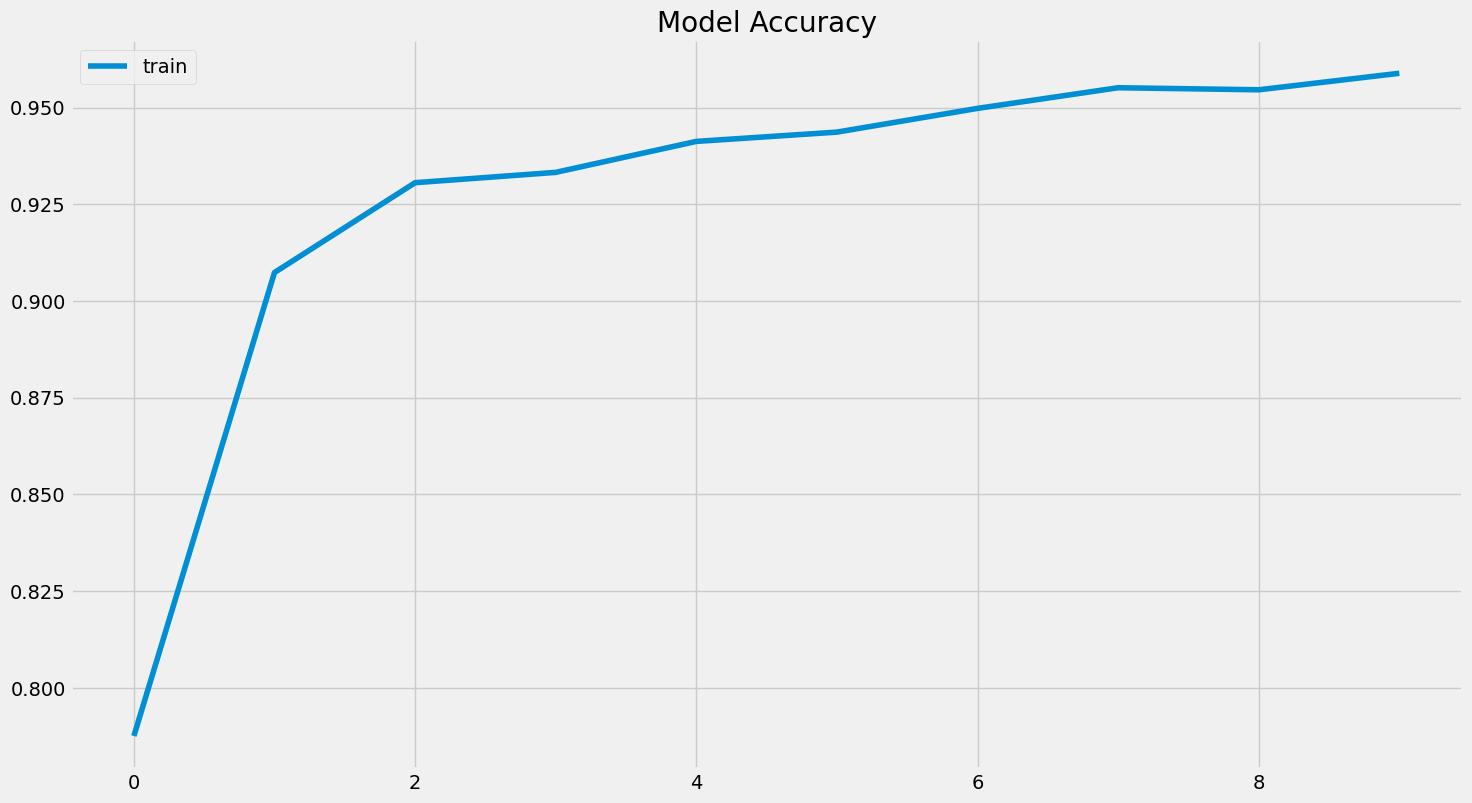

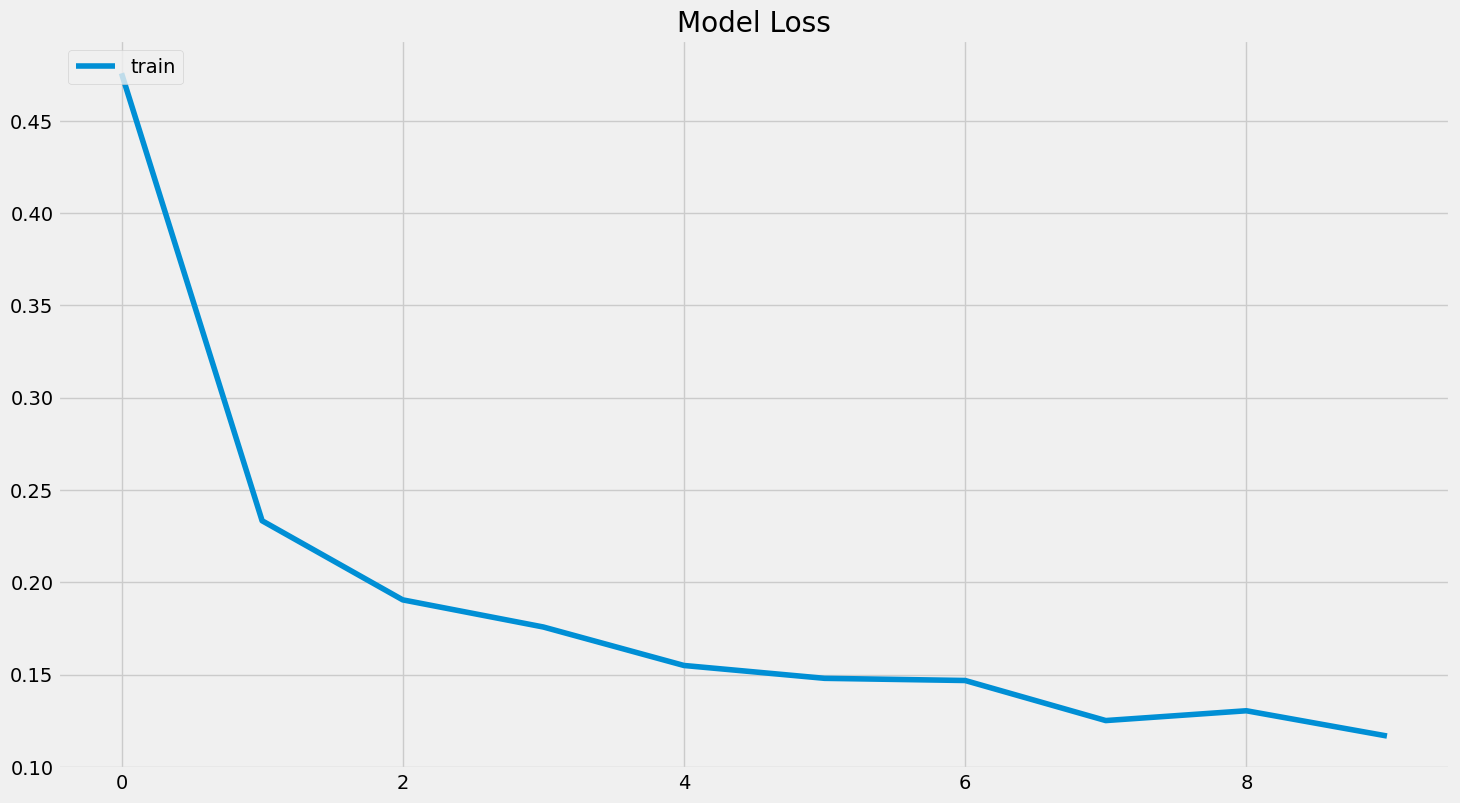

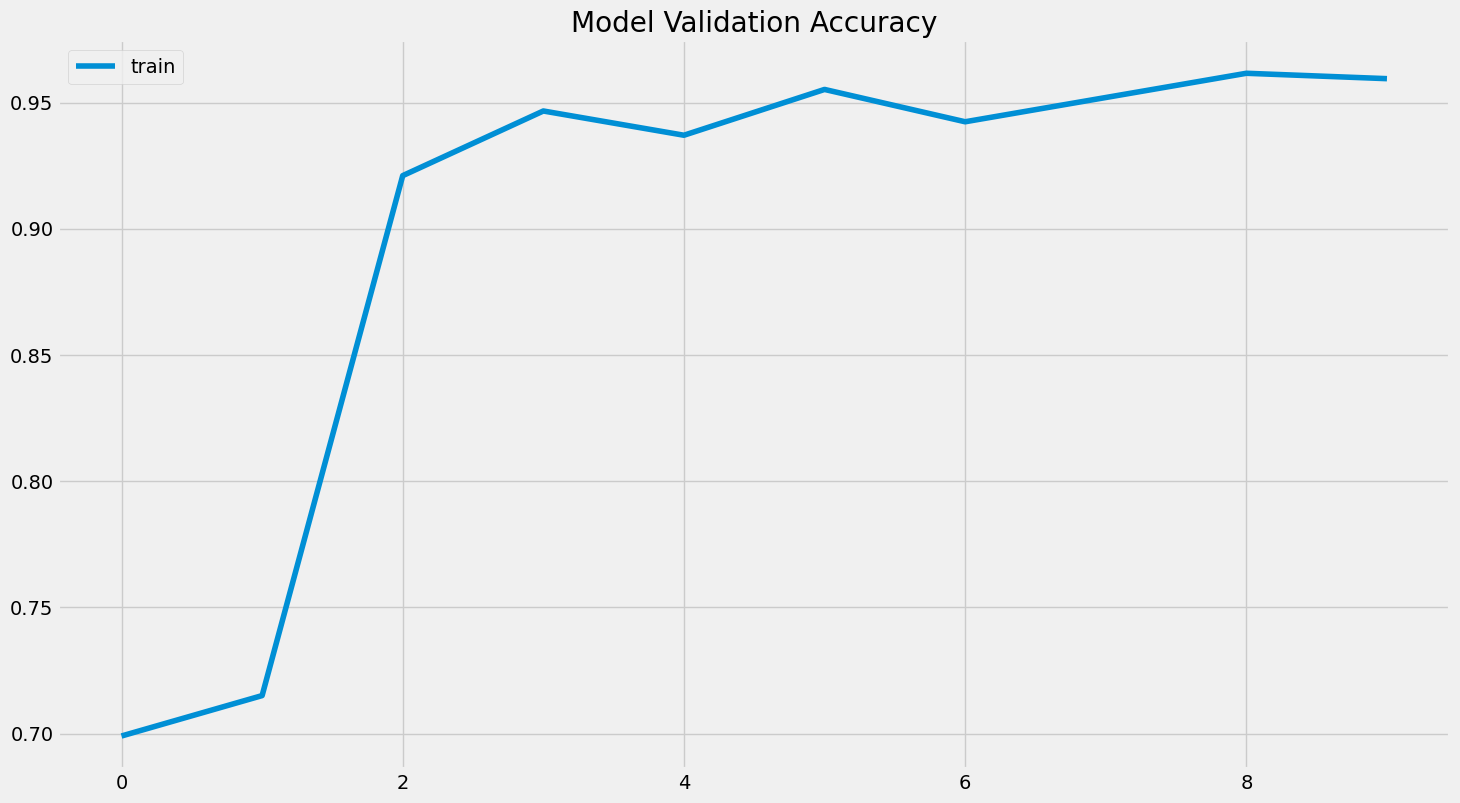

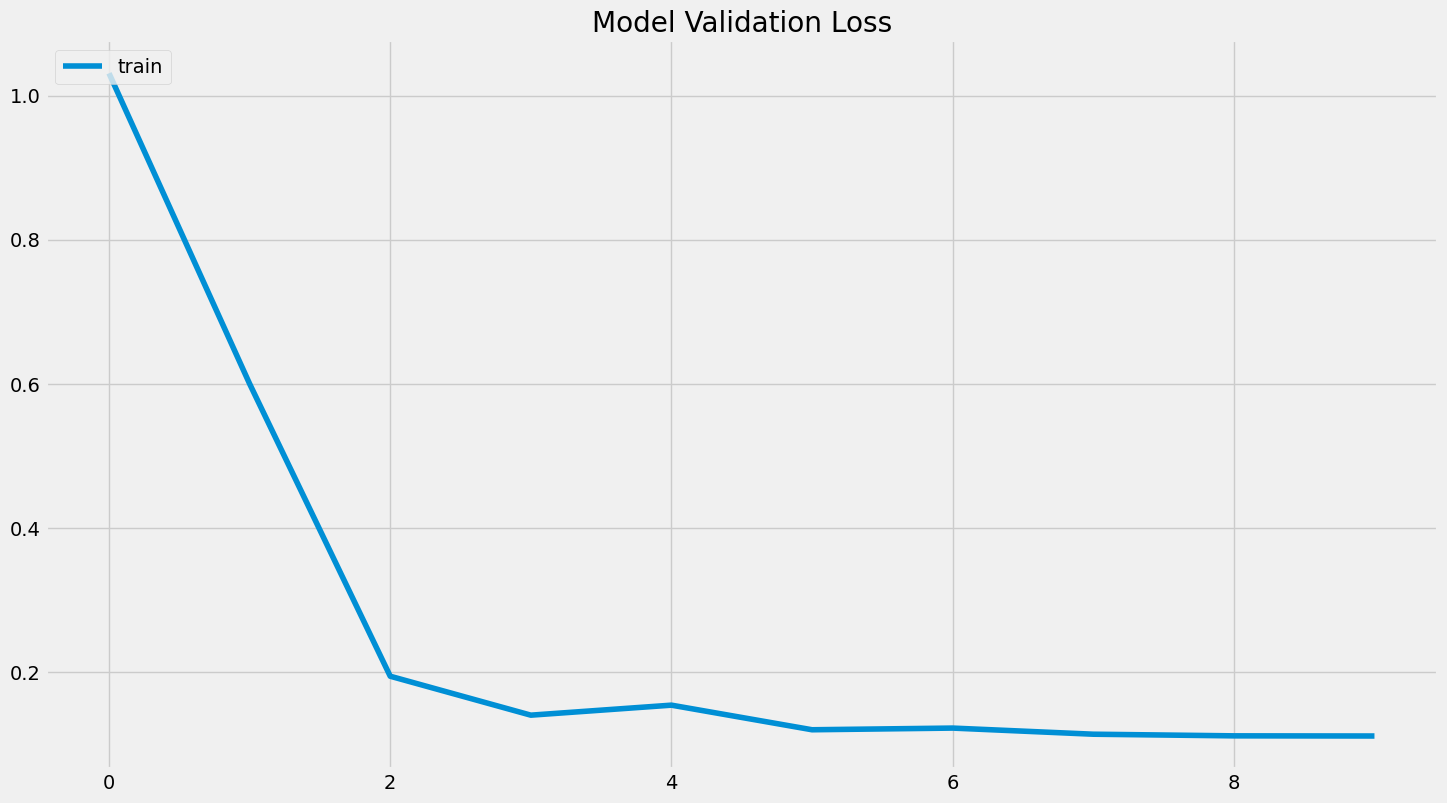

In [76]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

<h2>Prepare data for precision vs. recall and ROC</h2>

In [77]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


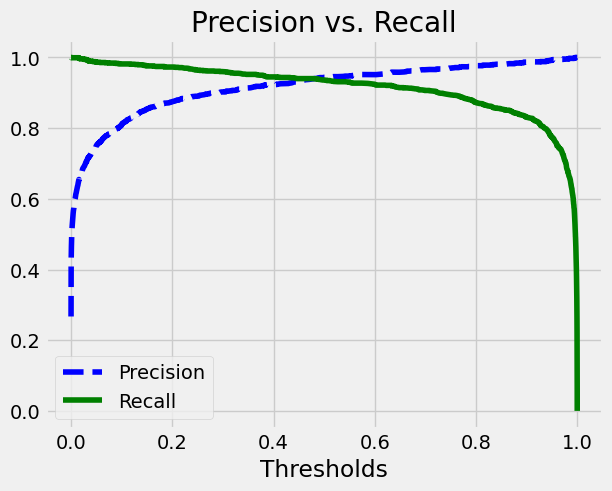

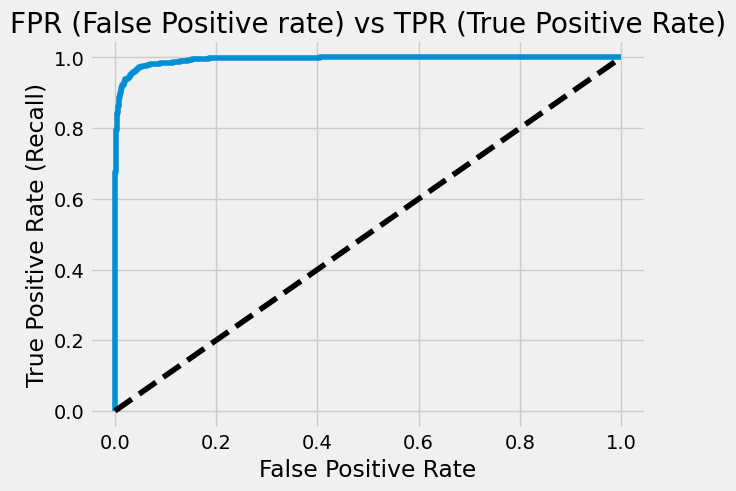

In [78]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()

plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [79]:
predictions = model.predict(X_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


<h2>Set thresholds for our model, we want the results to be precise while not sacraficing too much recall </h2>

In [80]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.95)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [81]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9581911262798635
Precision on testing set: 0.9088145896656535
Recall on testing set: 0.940251572327044


<h2>Plotting the confusion matrix. Here is how we interpet one. </h2>

Image source: https://silvrback.s3.amazonaws.com/uploads/4ab81a17-4a77-4e9e-b092-de5fac2afa07/confusionmatrix_large.png

![](https://silvrback.s3.amazonaws.com/uploads/4ab81a17-4a77-4e9e-b092-de5fac2afa07/confusionmatrix_large.png)

[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

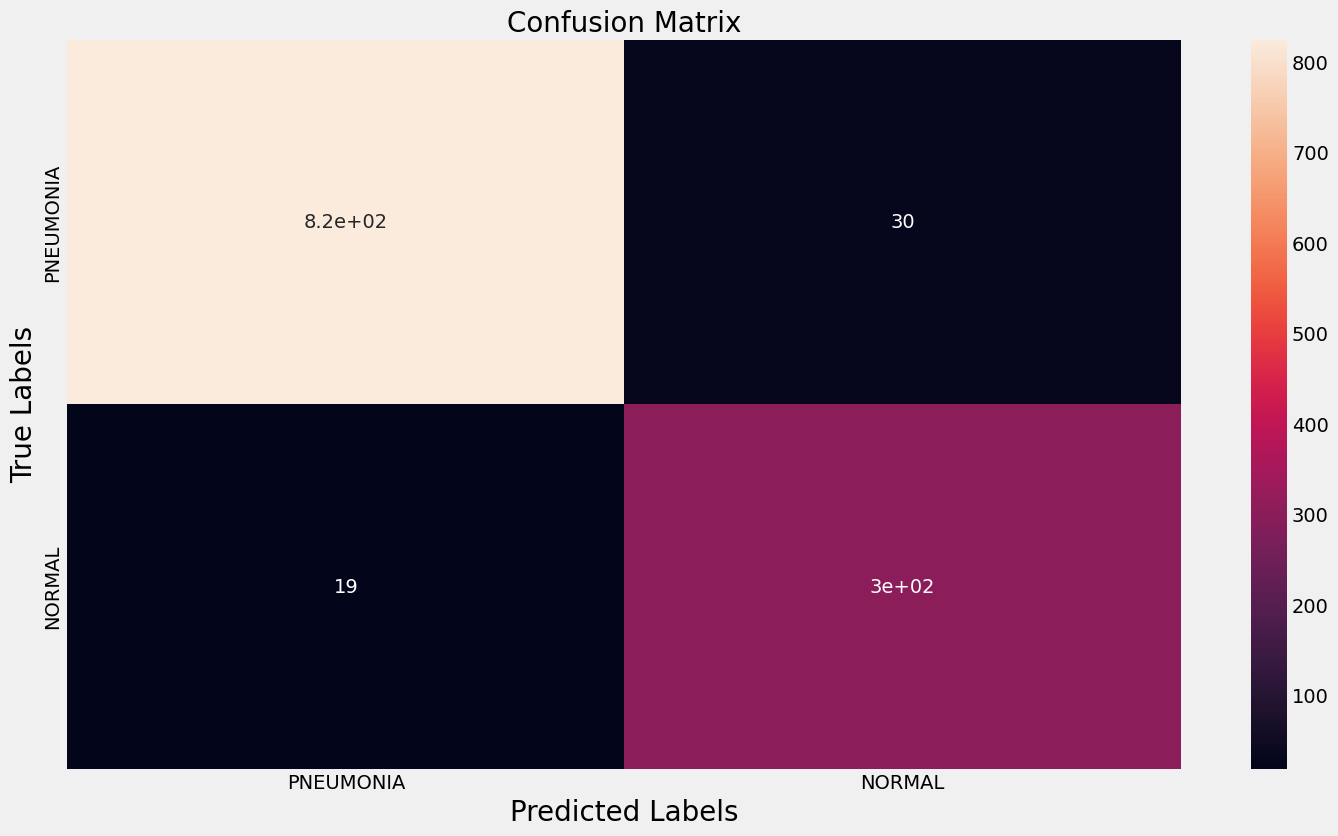

In [82]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

<h2>View some results from a sample of 15 images</h2>

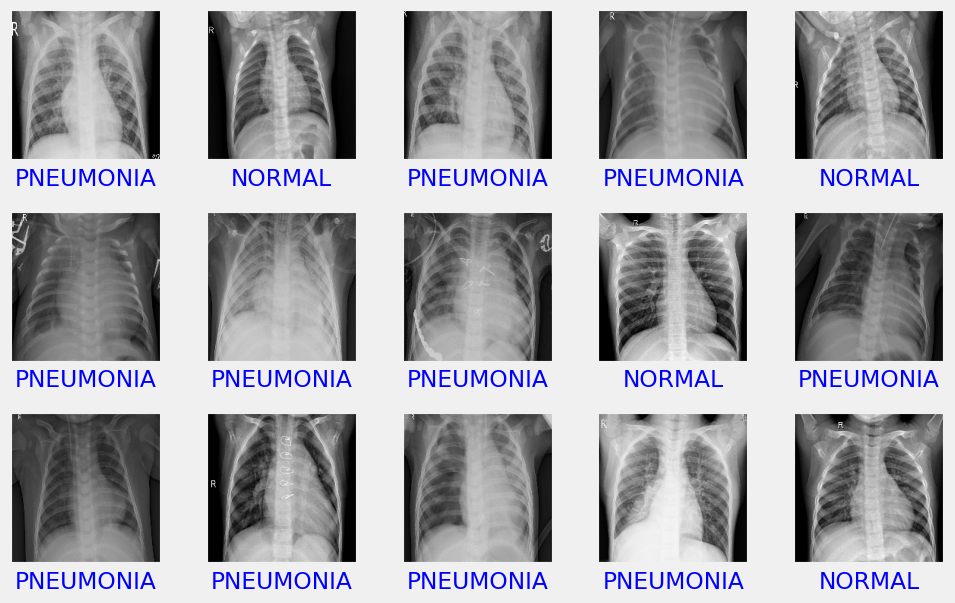

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming img_size is defined, and X_test, y_test, binary_predictions, and labels are available

# Set the number of images to display
num_images = 15

# Generate random indices from the test set
random_indices = np.random.choice(y_test.shape[0], num_images, replace=False)

plt.figure(figsize=(10, 10))  # Adjust the figure size for better visibility
for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)  # Create a 5x5 grid
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Show the randomly selected image from the corresponding index
    plt.imshow(X_test[idx].reshape(img_size, img_size), cmap='gray')

    # Check if the prediction matches the true label
    if binary_predictions[idx] == y_test[idx]:
        plt.xlabel(labels[binary_predictions[idx]], color='blue')  # Correct prediction in blue
    else:
        plt.xlabel(labels[binary_predictions[idx]], color='red')  # Incorrect prediction in red

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


<h2>Download the model</h2>

In [84]:
 model.save('pneumonia_detection_ai_version_2.h5')

<h2>Reflection: </h2>
<h3> There are a lot of rooms to improve. As we can see the dataset is inbalanced. Data augmentation might be appropriate in this scenario. If you have any questions or suggestions, please leave a comment below.</h3>